# Anticipez les besoins en consommation électrique de bâtiments

## Nettoyage, exploration et transformations des données

* [Chargement et aperçu de jeu de données](#Chargement-et-aperçu-de-jeu-de-données)
* [Nettoyage du jeu de données](#Nettoyage-du-jeu-de-données)
* [Détection et traitement des valeurs manquantes](#Détection-et-traitement-des-valeurs-manquantes)
* [Analyse Exploratoire des Données](#Analyse-Exploratoire-des-Données)
* [Répartition des valeurs des variables catégorielles](#Répartition-des-valeurs-des-variables-catégorielles)
* [Discritisation des variables catégorielles YearBuilt et NumberofFloors](#Discritisation-des-variables-catégorielles-YearBuilt-et-NumberofFloors)
* [Encodage de variables catégorielles](#Encodage-de-variables-catégorielles)
* [Corrélation entre variables](#Corrélation-entre-variables)
* [Enregistrer le dataset final sous format csv](#Enregistrer-le-dataset-final-sous-format-csv)

In [1]:
import sys

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest

from IPython.display import display_html
#pd.set_option("display.max_colwidth", 150)
pd.set_option('display.max_column', None)

### Fonctions

In [2]:
def formats(dataframe, name):
    formats = pd.DataFrame([dataframe.shape],
                       columns=['Nbre de lignes','Nbre de variables'],
                       index=[name])
    return formats

In [3]:
def get_types_objects(df):
    df_object = pd.DataFrame()
    df_float = pd.DataFrame()
    df_int = pd.DataFrame()
    df_bool = pd.DataFrame()
    for col in df.columns:
        if ((df[col].dtypes == 'object')):
            df_object[col] = df[col]
        elif (df[col].dtypes == 'int64'):
            df_int[col] = df[col]
        elif((df[col].dtypes == 'bool')):
            df_bool[col] = df[col]
        else:
            df_float[col] = df[col]
            
    return df_object, df_int, df_float,df_bool

In [4]:
def colunmLigneDuplicated(dataframe, name):
    a = dataframe.columns.duplicated().sum()
    b = dataframe.duplicated().sum()
    duplicated = pd.DataFrame([(str(a),str(b))],
                       columns=['Colonnes dupliquées','Lignes dupliquées'],
                       index=[name])
    return duplicated

In [5]:
def data_count_percent(dataframe):
    for col in dataframe.columns:
        data_count_percent = pd.DataFrame({
            'count': dataframe.isna().sum(),
            'percent': 100 * dataframe.isna().sum() / dataframe.shape[0]})
        # Transposition de la data
        
    return data_count_percent.sort_values(by = 'percent')

In [6]:
def ratio(dataframe, perc):
    data_clean = dataframe[dataframe.columns[(dataframe.isna().sum()/dataframe.shape[0]) < perc]]
    return data_clean

In [7]:
def vars_types(df):
    df_objet, df_int, df_float, df_bool = get_types_objects(df)
    types = {'Objet':df_objet.shape[1],
        'Float':df_float.shape[1],
        'Int':df_int.shape[1],
        'Bool':df_bool.shape[1]
    }
    return pd.DataFrame([types.values()], columns=types.keys(),index=[''])

In [8]:
def calculModalites(df, column):
    mods = pd.DataFrame(df[df[column].notnull()][column].value_counts(normalize=False))
    modalites = pd.DataFrame(mods.values, index=mods.index, columns=['Nbre Modalité']).sort_index()
    modalites.index.names = ['Modalités']
    return modalites

In [9]:
def encodage_cat_dummies(df, col, prefix):
    dum_df  = pd.DataFrame()
    modalites = df[col].unique()
    print(modalites)
    dum_df = pd.get_dummies(df[col], columns=[col], prefix=prefix)
    df = df.join(dum_df)
    return df

In [10]:
def dessinerCamembert(df, col):
    plt.figure(figsize=(20,8))

    colors = sns.color_palette('bright')[0:5]
    plt.title('Répartition des '+col+' en %', size=20)
    wedges, texts, autotexts = plt.pie(df[col].value_counts().values, 
            labels = df[col].value_counts().index.str.upper(),
           autopct='%1.1f%%', textprops={'fontsize': 16 } , colors = colors)


    ax = plt.gca()

    ax.legend(wedges, df[col].value_counts().index.str.upper(),
              title=col,
              loc="upper left",
              fontsize=14,
              bbox_to_anchor=(1, 0, 0.5, 1))
    #fct_exp.save_fig("repartition_grades_nutriscores_perc")



    plt.figure(figsize=(20,8))

    sns.set_theme(style="whitegrid")
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title('Répartition des '+col, size=20)
    #fct_exp.save_fig("repartition_grades_nutriscores_count")
    plt.show()

In [11]:
def visuliser_nan(df):
    missing_data = round(df.isna().sum()*100/len(df),1)
    missing_data = pd.DataFrame(missing_data.reset_index())
    missing_data.columns=["variable","données manquantes"]
    missing_data = missing_data.sort_values(by="données manquantes",ascending=False)
    missing_data1 = missing_data
    fig = missing_data1.sort_values(by="données manquantes",ascending=True).plot.bar(x="variable", y="données manquantes",figsize=(16,7),color="coral",width=0.7)
    plt.xlabel('Variables',fontsize=14)
    plt.ylabel('Pourcentage de données manquantes', fontsize=14)
    fig.set_title("Données manquantes",fontsize=16) 

In [12]:
def dessinner_histogramme_boxplot(df, col, title):
    plt.figure(figsize=(50,10))
    df[col].hist(bins=10, figsize=(15,5))
    plt.title(title)
    plt.show()
    sns.color_palette()
    sns.boxplot(x=df[col])
    plt.title('')
    plt.show()

In [13]:
def display_dfs(dfs, gap=50, justify='center'):
    html = ""
    for title, df in dfs.items():  
        df_html = df._repr_html_()
        cur_html = f'<div> <h3>{title}</h3> {df_html}</div>'
        html +=  cur_html
    html= f"""
    <div style="display:flex; gap:{gap}px; justify-content:{justify};">
        {html}
    </div>
    """
    display_html(html, raw=True)

### Chargement et aperçu de jeu de données

In [14]:
# Chargement de jeu de données
df_Building_Energy = pd.read_csv('data/2016_Building_Energy_Benchmarking.csv')

##### Forme et structure de notre jeu de données

In [15]:
# Aperçu des données
df1 = formats(df_Building_Energy, '')
df2 = vars_types(df_Building_Energy)
df3 = colunmLigneDuplicated(df_Building_Energy,'')
dfs = {'Building Energy': df1, 'Types de variables': df2, 'Colonnes/Lignes dupliquées':df3}
display_dfs(dfs, justify='flex-start')

Building Energy 

 
 
 
 
 Nbre de lignes 
 Nbre de variables 
 
 
 
 
 
 3376 
 46 
 
 
 
 Types de variables 

 
 
 
 
 Objet 
 Float 
 Int 
 Bool 
 
 
 
 
 
 15 
 22 
 8 
 1 
 
 
 
 Colonnes/Lignes dupliquées 

 
 
 
 
 Colonnes dupliquées 
 Lignes dupliquées 
 
 
 
 
 
 0 
 0

                                                                                                                 
Nous disposons d'un jeu de données composé de 3376 observations et 46 variables. 
contient plus de variables numériques(30) que de variables catégorielles(15) et une variable boolienne           
Le jeu de données ne contient ni lignes ni colonnes dupliquées                                                                                                                                                                          

- Aperçu des données

In [16]:
df_Building_Energy.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [17]:
df_Building_Energy.tail()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3371,50222,2016,Nonresidential COS,Office,Horticulture building,1600 S Dakota St,Seattle,WA,NaN,1624049080,2,GREATER DUWAMISH,47.56722,-122.31154,1990,1.0,1,12294,0,12294,Office,Office,12294.0,NaN,NaN,NaN,NaN,NaN,46.0,69.099998,76.699997,161.699997,176.100006,8.497457e+05,9.430032e+05,0.0,153655.0000,5.242709e+05,3254.750244,3.254750e+05,True,NaN,Error - Correct Default Data,NaN,20.94,1.70
3372,50223,2016,Nonresidential COS,Other,International district/Chinatown CC,719 8th Ave S,Seattle,WA,NaN,3558300000,2,DOWNTOWN,47.59625,-122.32283,2004,1.0,1,16000,0,16000,Other - Recreation,Other - Recreation,16000.0,NaN,NaN,NaN,NaN,NaN,NaN,59.400002,65.900002,114.199997,118.900002,9.502762e+05,1.053706e+06,0.0,116221.0000,3.965461e+05,5537.299805,5.537300e+05,False,NaN,Compliant,NaN,32.17,2.01
3373,50224,2016,Nonresidential COS,Other,Queen Anne Pool,1920 1st Ave W,Seattle,WA,NaN,1794501150,7,MAGNOLIA / QUEEN ANNE,47.63644,-122.35784,1974,1.0,1,13157,0,13157,"Fitness Center/Health Club/Gym, Other - Recrea...",Other - Recreation,7583.0,Fitness Center/Health Club/Gym,5574.0,Swimming Pool,0.0,NaN,NaN,438.200012,460.100006,744.799988,767.799988,5.765898e+06,6.053764e+06,0.0,525251.6875,1.792159e+06,39737.390630,3.973739e+06,False,NaN,Compliant,NaN,223.54,16.99
3374,50225,2016,Nonresidential COS,Mixed Use Property,South Park Community Center,8319 8th Ave S,Seattle,WA,NaN,7883603155,1,GREATER DUWAMISH,47.52832,-122.32431,1989,1.0,1,14101,0,14101,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,6601.0,Fitness Center/Health Club/Gym,6501.0,Pre-school/Daycare,484.0,NaN,NaN,51.000000,55.500000,105.300003,110.800003,7.194712e+05,7.828413e+05,0.0,102248.0000,3.488702e+05,3706.010010,3.706010e+05,False,NaN,Compliant,NaN,22.11,1.57
3375,50226,2016,Nonresidential COS,Mixed Use Property,Van Asselt Community Center,2820 S Myrtle St,Seattle,WA,NaN,7857002030,2,GREATER DUWAMISH,47.53939,-122.29536,1938,1.0,1,18258,0,18258,"Fitness Center/Health Club/Gym, Food Service, ...",Other - Recreation,8271.0,Fitness Center/Health Club/Gym,8000.0,Pre-school/Daycare,1108.0,NaN,NaN,63.099998,70.900002,115.800003,123.900002,1.152896e+06,1.293722e+06,0.0,126774.3984,4.325542e+05,7203.419922,7.203420e+05,False,NaN,Compliant,NaN,41.27,2.26


In [18]:
df_Building_Energy.sample(10)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
640,1280,2016,NonResidential,Mixed Use Property,Filson World Headquarters LP,1741 1st Ave S,Seattle,WA,98134.0,7666207095,2,GREATER DUWAMISH,47.58718,-122.33467,1921,1.0,3,66138,12586,53552,"Manufacturing/Industrial Plant, Office, Parkin...",Office,26044.0,Manufacturing/Industrial Plant,13884.0,Parking,13858.0,NaN,3.0,139.800003,139.800003,439.000000,439.000000,7.070998e+06,7070998.50,0.0,2.072391e+06,7070998.0,0.000000,0.0,False,NaN,Compliant,NaN,49.29,0.75
422,581,2016,NonResidential,Other,Meridian Medical Pavilion,11011 Meridian Ave N,Seattle,WA,98133.0,3026049051,5,NORTHWEST,47.70887,-122.33494,2005,1.0,3,161789,91935,69854,"Medical Office, Parking",Parking,91935.0,Medical Office,69854.0,NaN,NaN,NaN,NaN,99.699997,101.099998,312.500000,317.100006,6.963616e+06,7063953.50,0.0,2.036227e+06,6947606.0,160.100006,16010.0,False,NaN,Compliant,NaN,49.28,0.30
583,780,2016,NonResidential,Large Office,King Street Center,201 South Jackson A-15,Seattle,WA,98104.0,5247800795,2,DOWNTOWN,47.59878,-122.33088,1998,1.0,8,446261,124788,321473,"Office, Parking",Office,343400.0,Parking,114237.0,NaN,NaN,2014201020082001,96.0,39.500000,39.500000,124.099998,124.099998,1.356815e+07,13568148.00,0.0,3.976596e+06,13568146.0,0.000000,0.0,False,NaN,Compliant,NaN,94.59,0.21
600,802,2016,NonResidential,Supermarket / Grocery Store,70500849 -- Rainier Valley,2707 Rainier Avenue South,Seattle,WA,98144.0,5260300005,2,GREATER DUWAMISH,47.57903,-122.29982,1963,1.0,1,50785,0,50785,Supermarket/Grocery Store,Supermarket/Grocery Store,27382.0,NaN,NaN,NaN,NaN,NaN,57.0,271.700012,277.299988,615.599976,618.099976,7.439009e+06,7593035.00,0.0,1.268266e+06,4327325.0,31116.835940,3111684.0,False,NaN,Compliant,NaN,195.43,3.85
3075,28068,2016,Multifamily HR (10+),High-Rise Multifamily,Rollin Street Flats,120 Westlake Ave N,Seattle,WA,98109.0,7398000000,7,LAKE UNION,47.61921,-122.33807,2007,1.0,11,399935,0,399935,"Multifamily Housing, Parking",Multifamily Housing,220280.0,Parking,19285.0,NaN,NaN,NaN,20.0,64.500000,66.099998,128.600006,129.500000,1.420428e+07,14561657.00,0.0,1.879908e+06,6414247.0,77900.328130,7790033.0,False,NaN,Compliant,NaN,458.44,1.15
3251,49902,2016,Multifamily MR (5-9),Mid-Rise Multifamily,Viva,1111 E Union St,Seattle,WA,98122.0,3225049001,3,EAST,47.61272,-122.31761,2014,1.0,6,123075,31916,91159,"Multifamily Housing, Parking",Multifamily Housing,82627.0,Parking,32227.0,NaN,NaN,NaN,95.0,33.400002,33.900002,79.599998,80.099998,2.759072e+06,2799192.50,0.0,5.156851e+05,1759518.0,9995.537109,999554.0,False,NaN,Compliant,NaN,65.35,0.53
1888,23708,2016,Multifamily LR (1-4),Low-Rise Multifamily,Anne Vista Apartments,2416-2420 54th Pl Sw,Seattle,WA,98116.0,3505100761,1,SOUTHWEST,47.58229,-122.40147,1957,1.0,3,20184,0,20184,Multifamily Housing,Multifamily Housing,20184.0,NaN,NaN,NaN,NaN,NaN,100.0,8.200000,8.700000,25.600000,27.200001,1.648179e+05,175114.50,0.0,4.830540e+04,164818.0,0.000000,0.0,False,NaN,Non-Compliant,Low outlier,1.15,0.06
2158,24626,2016,Multifamily LR (1-4),Low-Rise Multifamily,Ray,3636 Stone Way North,Seattle,WA,98103.0,8033700215,4,LAKE UNION,47.65157,-122.34231,2015,2.0,4,131034,28681,102353,"Multifamily Housing, Parking, Restaurant",Multifamily Housin

In [19]:
df_Building_Energy.drop('ZipCode',axis=1).describe(include=np.float64)

,Latitude,Longitude,NumberofBuildings,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.000000,3368.000000,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,47.624033,-122.334795,1.106888,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,0.047758,0.027203,2.108402,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,47.499170,-122.414250,0.000000,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,47.599860,-122.350662,1.000000,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,47.618675,-122.332495,1.000000,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,47.657115,-122.319407,1.000000,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,47.733870,-122.220966,111.000000,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


In [20]:
df_Building_Energy.describe(include=np.int64)

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s)
count,3376.000000,3376.0,3376.000000,3376.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03
mean,21208.991114,2016.0,4.439277,1968.573164,4.709123,9.483354e+04,8001.526066,8.683201e+04
std,12223.757015,0.0,2.120625,33.088156,5.494465,2.188376e+05,32326.723928,2.079398e+05
min,1.000000,2016.0,1.000000,1900.000000,0.000000,1.128500e+04,0.000000,3.636000e+03
25%,19990.750000,2016.0,3.000000,1948.000000,2.000000,2.848700e+04,0.000000,2.775600e+04
50%,23112.000000,2016.0,4.000000,1975.000000,4.000000,4.417500e+04,0.000000,4.321600e+04
75%,25994.250000,2016.0,7.000000,1997.000000,5.000000,9.099200e+04,0.000000,8.427625e+04
max,50226.000000,2016.0,7.000000,2015.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06


In [21]:
df_Building_Energy.describe(include=object)

,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,Neighborhood,ListOfAllPropertyUseTypes,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,YearsENERGYSTARCertified,ComplianceStatus,Outlier
count,3376,3376,3376,3376,3376,3376,3376,3376,3367,3356,1679,596,119,3376,32
unique,8,24,3362,3354,1,1,3268,19,466,56,50,44,65,4,2
top,NonResidential,Low-Rise Multifamily,Northgate Plaza,2600 SW Barton St,Seattle,WA,1625049001,DOWNTOWN,Multifamily Housing,Multifamily Housing,Parking,Retail Store,2016,Compliant,Low outlier
freq,1460,987,3,4,3376,3376,8,573,866,1667,976,110,14,3211,23


In [22]:
df_Building_Energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

##### Modalités des variables catégorielles

In [23]:
df0 = calculModalites(df_Building_Energy, 'ListOfAllPropertyUseTypes')
df1 = calculModalites(df_Building_Energy, 'BuildingType')
df2 = calculModalites(df_Building_Energy, 'PropertyName')

df3 = calculModalites(df_Building_Energy, 'PrimaryPropertyType')
df4 = calculModalites(df_Building_Energy, 'LargestPropertyUseType')
df5 = calculModalites(df_Building_Energy, 'SecondLargestPropertyUseType')
df6 = calculModalites(df_Building_Energy, 'ThirdLargestPropertyUseType')

df7 = calculModalites(df_Building_Energy, 'City')
df8 = calculModalites(df_Building_Energy, 'Neighborhood')
df9 = calculModalites(df_Building_Energy, 'Outlier')
df10 = calculModalites(df_Building_Energy, 'ComplianceStatus')


In [24]:
dfs = {
       'BuildingType': df1.sort_values(by='Nbre Modalité', ascending=False),
       'PropertyName': df2.sort_values(by='Nbre Modalité', ascending=False), 
       'ListOfAllPropertyUseTypes':df0.sort_values(by='Nbre Modalité', ascending=False)
        }
display_dfs(dfs, justify='flex-start')

,Nbre Modalité
Modalités,
NonResidential,1460
Multifamily LR (1-4),1018
Multifamily MR (5-9),580
Multifamily HR (10+),110
SPS-District K-12,98
Nonresidential COS,85
Campus,24
Nonresidential WA,1
,Nbre Modalité


In [25]:
dfs = {'PrimaryPropertyType':df3.sort_values(by='Nbre Modalité', ascending=False) ,
       'LargestPropertyUseType': df4.sort_values(by='Nbre Modalité', ascending=False), 
       'SecondLargestPropertyUseType': df5.sort_values(by='Nbre Modalité', ascending=False), 
       'ThirdLargestPropertyUseType':df6.sort_values(by='Nbre Modalité', ascending=False) }
display_dfs(dfs, justify='flex-start')

,Nbre Modalité
Modalités,
Low-Rise Multifamily,987
Mid-Rise Multifamily,564
Small- and Mid-Sized Office,293
Other,256
Warehouse,187
Large Office,173
K-12 School,139
Mixed Use Property,133
High-Rise Multifamily,105


In [26]:
dfs = {'Neighborhood': df8.sort_values(by='Nbre Modalité', ascending=False), 
       'ComplianceStatus':df10.sort_values(by='Nbre Modalité', ascending=False),
       'Outlier': df9.sort_values(by='Nbre Modalité', ascending=False),
       'City':df7.sort_values(by='Nbre Modalité', ascending=False) 
       }
display_dfs(dfs, justify='flex-start')

,Nbre Modalité
Modalités,
DOWNTOWN,573
EAST,453
MAGNOLIA / QUEEN ANNE,423
GREATER DUWAMISH,375
NORTHEAST,280
LAKE UNION,251
NORTHWEST,210
SOUTHWEST,166
NORTH,145


### Nettoyage du jeu de données

- Neighborhood

In [27]:
valeurs_avant = ['Delridge','DELRIDGE NEIGHBORHOODS','North','Northwest','Ballard','Central']
valeurs_apres = ['DELRIDGE','DELRIDGE','NORTH','NORTHWEST','BALLARD','CENTRAL']
df_Building_Energy.replace(to_replace =valeurs_avant,value =valeurs_apres, inplace=True)

In [28]:
df_Building_Energy.shape

(3376, 46)

- ComplianceStatus

In [29]:
#Lignes à supprimer : 'ComplianceStatus' == 'Error - Correct Default Data'
lignesASupprimer_ComplianceStatus = df_Building_Energy[(df_Building_Energy['ComplianceStatus'] == 'Error - Correct Default Data')]
df_Building_Energy.drop(lignesASupprimer_ComplianceStatus.index, axis=0, inplace=True)

In [30]:
df_Building_Energy.shape

(3263, 46)

. 113 lignes ont éré supprimées

- BuildingType : Suppréssion des propriétés destinées à l'habitat

In [31]:
data_NR = df_Building_Energy[df_Building_Energy["BuildingType"].str.contains("NonResidential|Nonresidential COS|Nonresidential WA|SPS-District K-12")]

In [32]:
data_NR.shape

(1556, 46)

1707 lignes correspondant aux propriétés désinés à l'habitat ont été supprimées

- Suppréssion des observations dont les valeurs de la variable 'Outlier' =  High outlier | Low outlier

In [33]:
high_outliers = data_NR[data_NR['Outlier'] == 'High outlier']
df = data_NR.drop(high_outliers.index, axis=0)
low_outliers = df[df['Outlier'] == 'Low outlier']
data_cleaned = df.drop(low_outliers.index, axis=0)

In [34]:
data_cleaned.shape

(1541, 46)

15 lignes ont été supprimées

- Format du jeu de données nettoyé

In [35]:
df = formats(data_cleaned, '')
dfs = {'Jeu de données nettoyé': df}
display_dfs(dfs, justify='flex-start')

,Nbre de lignes,Nbre de variables
,1541,46


Le nouveau de jeu de données **data_cleaned** contient 1541 observations (1835 observations ont été supprimées!)

### Détection et traitement des valeurs manquantes

###### Taux des valeurs manquantes

<AxesSubplot:>

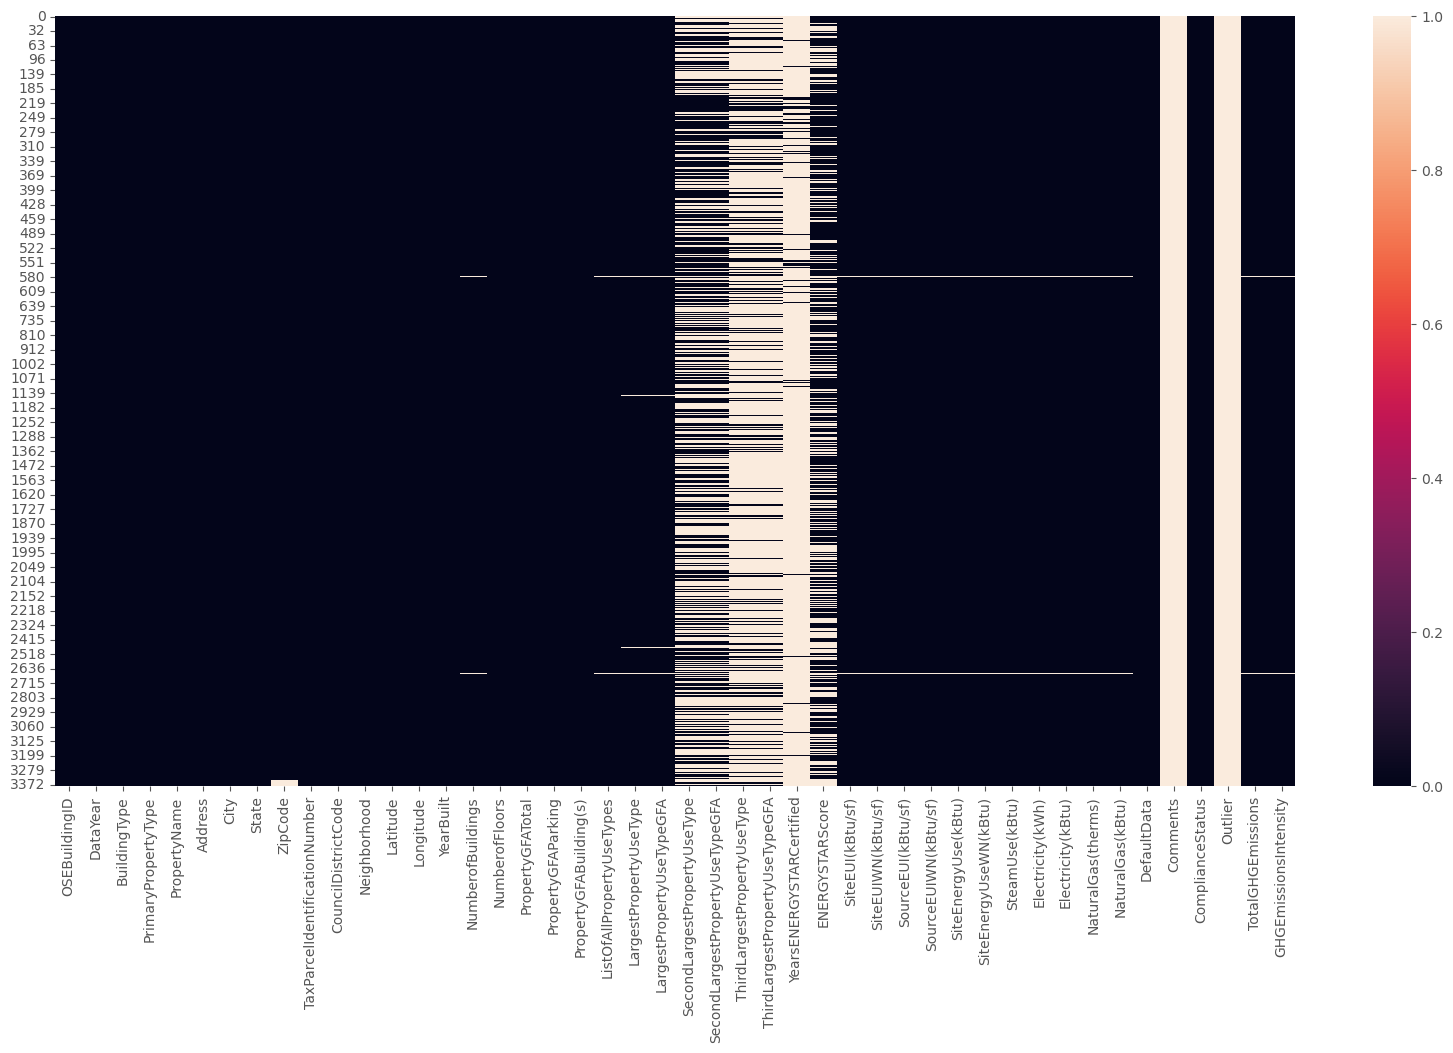

In [36]:
#Visualison des Nan dans une Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(data_cleaned.isna(), cbar=True)

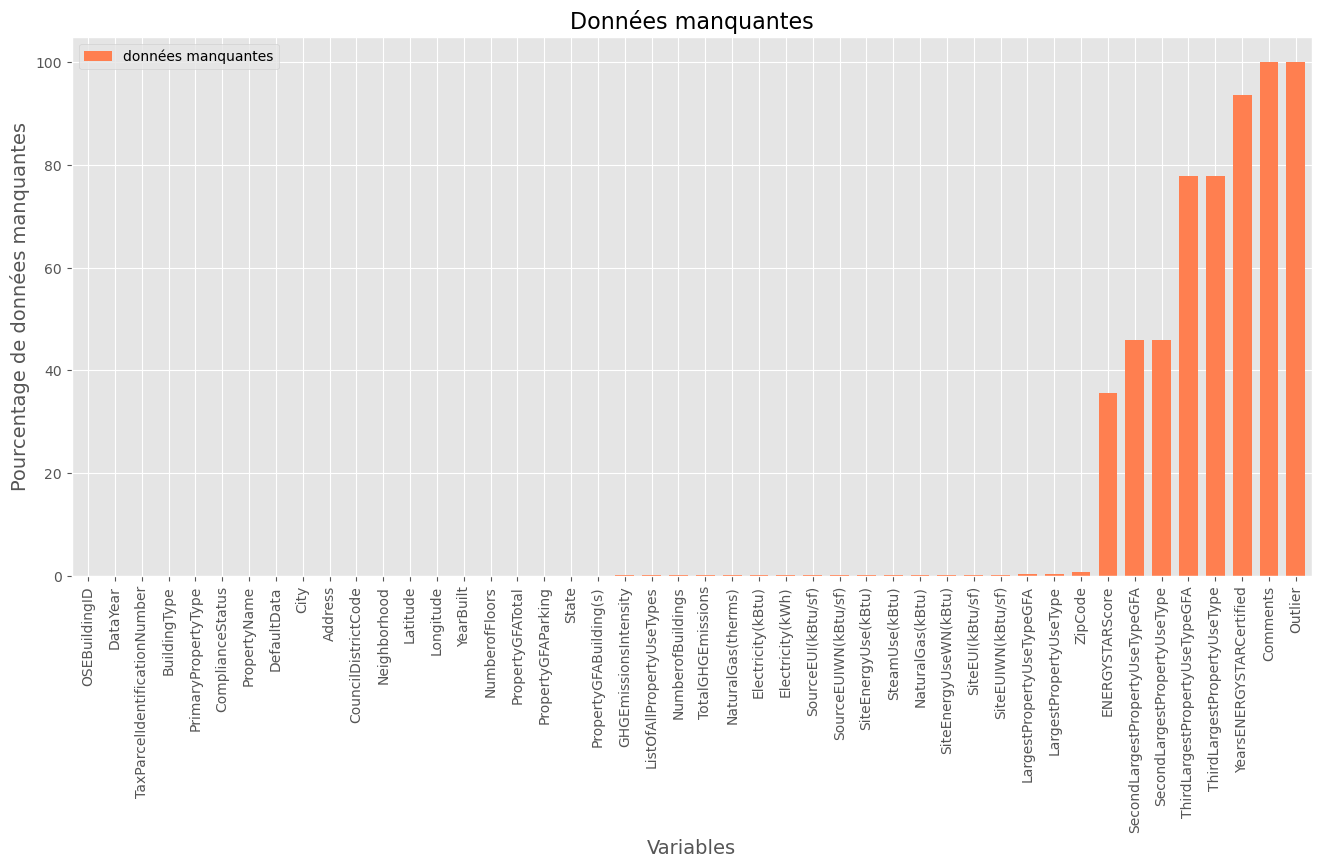

In [37]:
#Visualisation graphique
visuliser_nan(data_cleaned)

Ces deux graphiques nous monterent que les variables **'Comments','Outlier'** ne contiennent que des valeurs manquantes.D'autres en contiennent plus de 75%

###### Traitement des valeurs manquantes

- Nous supprimons les variables contenant plus de 75% de NaN

In [38]:
# New dataset : new_data 
new_data = ratio(data_cleaned, 0.75)

In [39]:
df1 = formats(new_data, '')
df2 = vars_types(new_data)
dfs = {'Building Energy': df1, 'Types de variables': df2}
display_dfs(dfs, justify='flex-start')

Building Energy 

 
 
 
 
 Nbre de lignes 
 Nbre de variables 
 
 
 
 
 
 1541 
 41 
 
 
 
 Types de variables 

 
 
 
 
 Objet 
 Float 
 Int 
 Bool 
 
 
 
 
 
 12 
 20 
 8 
 1

On passe de 46 à 41 variables qui contiennent toutes moins de 75% de nan

In [40]:
print("Les variables comportant plus de 75% de nan et qui ont été supprimées:")
for column in data_cleaned.columns:
    if column not in new_data.columns :
        print("-{}".format(column))

Les variables comportant plus de 75% de nan et qui ont été supprimées:
-ThirdLargestPropertyUseType
-ThirdLargestPropertyUseTypeGFA
-YearsENERGYSTARCertified
-Comments
-Outlier


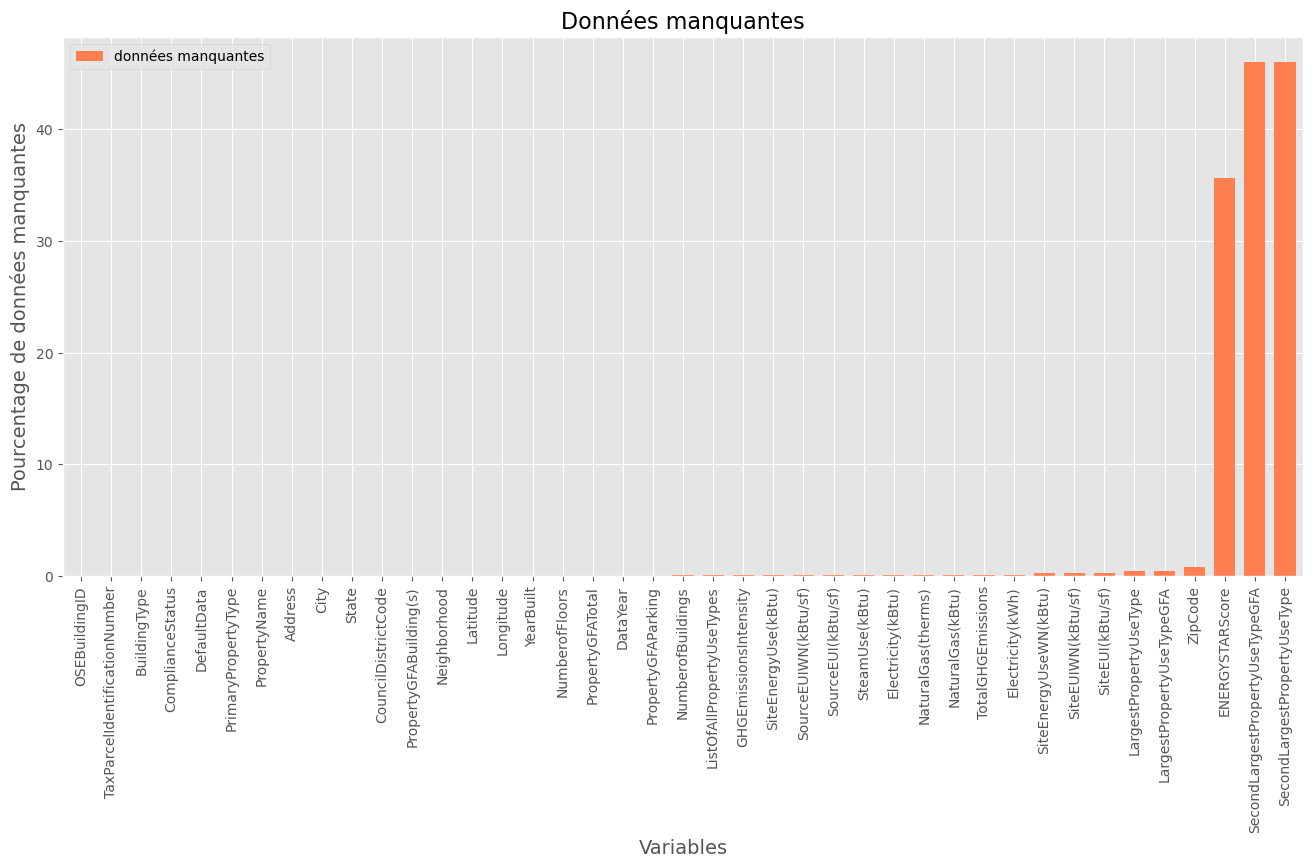

In [41]:
#Visualisation graphique
visuliser_nan(new_data)

In [42]:
#data_count_percent(new_data)

- O et n constate que les variables **SecondLargestPropertyUseTypeGFA** et **SecondLargestPropertyUseType** ont 46% des NaN

- Traitement des variables surface

In [43]:
surface_columns = ['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking',
                   'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA'
                  ]

In [44]:
new_data[surface_columns].sample(20)

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA
274,135918,135918,0,144570.0,NaN
511,158931,130550,28381,80157.0,34302.0
1657,28841,28841,0,28841.0,NaN
1591,23032,23032,0,14448.0,5300.0
1877,25912,17956,7956,17332.0,9162.0
2784,20992,20992,0,24600.0,4625.0
1754,274568,274568,0,228133.0,135954.0
788,63990,37350,26640,39000.0,26640.0
2489,25000,25000,0,13393.0,7500.0
3165,45700,45700,0,293707.0,NaN


In [45]:
new_data[new_data['PropertyGFATotal'] < new_data['LargestPropertyUseTypeGFA']][surface_columns]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA
11,333176,272015,61161,336640.0,NaN
31,51582,51582,0,55166.0,NaN
43,332210,126240,205970,348630.0,NaN
59,217603,217603,0,296313.0,0.0
62,53352,53352,0,65568.0,NaN
...,...,...,...,...,...
3294,33648,33648,0,83600.0,39000.0
3319,144614,144614,0,159500.0,NaN
3322,108036,108036,0,202171.0,108036.0
3347,45000,45000,0,45728.0,0.0


- On constate que la surface de la variable **LargestPropertyUseTypeGFA** est plus grand que celle de la variable **PropertyGFATotal**

In [46]:
# On supprime les variables surfaces incohérentes
vars_surfaces_to_delete = ['LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
                           'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
    ]

In [47]:
new_data = new_data.drop(vars_surfaces_to_delete, axis=1).copy()

On vérifie que la surface totale d'une propriété est supérieur ou égale à l'addition des deux surfaces suivantes : **PropertyGFABuilding(s)** et  **PropertyGFAParking**

In [48]:
new_data[new_data['PropertyGFATotal'] < new_data['PropertyGFABuilding(s)']+ new_data['PropertyGFAParking']][['PropertyGFATotal', 'PropertyGFABuilding(s)', 'PropertyGFAParking']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking


Les variables surfaces sont donc cohérentes

In [49]:
new_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
PropertyName                       0
Address                            0
City                               0
State                              0
ZipCode                           13
TaxParcelIdentificationNumber      0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofBuildings                  2
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
ListOfAllPropertyUseTypes          2
ENERGYSTARScore                  549
SiteEUI(kBtu/sf)                   3
SiteEUIWN(kBtu/sf)                 3
SourceEUI(kBtu/sf)                 2
SourceEUIWN(kBtu/sf)               2
SiteEnergyUse(kBtu)                2
S

- On constate que nos variables cibles **TotalGHGEmissions** et **SourceEUI(kBtu/sf)** comportent deux NaN chacune, on supprimera les obsévations correspondantes

In [50]:
# suppréssion de la variable **ZipCode**
new_data.drop('ZipCode', axis=1, inplace=True)

In [51]:
vars_objet, vars_int, vars_float, vars_bool = get_types_objects(new_data)

In [52]:
new_data[new_data['TotalGHGEmissions'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN


In [53]:
new_data[new_data['SiteEnergyUse(kBtu)'].isna()]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
578,773,2016,NonResidential,Small- and Mid-Sized Office,SEATTLE BUILDING,215 COLUMBIA ST,Seattle,WA,0939000245,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,63150,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN
2670,26532,2016,NonResidential,Mixed Use Property,KALBERG BUILDING,4515 UNIVERSITY WAY NE,Seattle,WA,8816401120,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,20760,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,Non-Compliant,NaN,NaN


In [54]:
new_data.dropna(subset=['TotalGHGEmissions','SiteEnergyUse(kBtu)'], inplace=True)

In [55]:
new_data.isna().sum()

OSEBuildingID                      0
DataYear                           0
BuildingType                       0
PrimaryPropertyType                0
PropertyName                       0
Address                            0
City                               0
State                              0
TaxParcelIdentificationNumber      0
CouncilDistrictCode                0
Neighborhood                       0
Latitude                           0
Longitude                          0
YearBuilt                          0
NumberofBuildings                  0
NumberofFloors                     0
PropertyGFATotal                   0
PropertyGFAParking                 0
PropertyGFABuilding(s)             0
ListOfAllPropertyUseTypes          0
ENERGYSTARScore                  547
SiteEUI(kBtu/sf)                   1
SiteEUIWN(kBtu/sf)                 1
SourceEUI(kBtu/sf)                 0
SourceEUIWN(kBtu/sf)               0
SiteEnergyUse(kBtu)                0
SiteEnergyUseWN(kBtu)              1
S

In [56]:
new_data[new_data['TotalGHGEmissions'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity
3206,49784,2016,NonResidential,Small- and Mid-Sized Office,Bullitt Center,1501 E. Madison St.,Seattle,WA,7234600195,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,52000,0,52000,Office,100.0,7.1,5.0,2.0,-2.1,342726.0938,240132.0938,0.0,-33826.80078,-115417.0,0.0,0.0,False,Compliant,-0.8,-0.02


In [57]:
new_data.drop(new_data[new_data['TotalGHGEmissions'] < 0].index,  axis=0, inplace=True)

In [58]:
new_data[new_data['SiteEnergyUse(kBtu)'] < 0]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,ComplianceStatus,TotalGHGEmissions,GHGEmissionsIntensity


- Imputation des NaN de la variable **ENERGYSTARScore** en utilisant l'algoritme **MissForest**

In [59]:
vars_objet, vars_int, vars_float, vars_bool = get_types_objects(new_data)

In [60]:
imputer = MissForest(criterion='squared_error',random_state=42)
X_imputed = pd.DataFrame(imputer.fit_transform(vars_float.values), columns=vars_float.columns, index=vars_float.index)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [61]:
temp = new_data.drop(X_imputed.columns, axis=1).copy()

In [62]:
data_filled = pd.concat([temp,X_imputed], axis=1).copy()

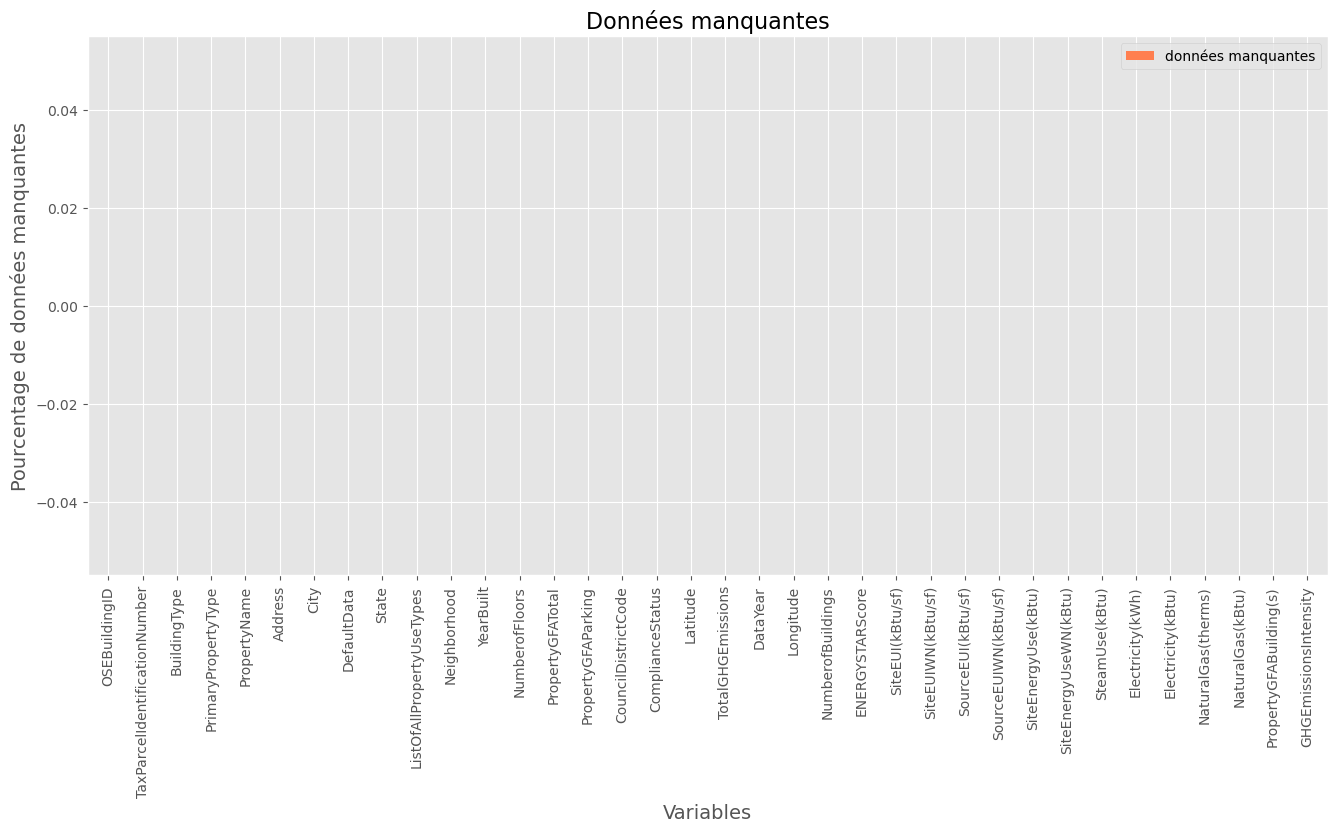

In [63]:
#Visualisation graphique
visuliser_nan(data_filled)

Aucune valeur manquante présente dans notre nouveau jeu de données

In [64]:
data_filled[['PropertyGFATotal','PropertyGFABuilding(s)','PropertyGFAParking']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking
0,88434,88434,0
1,103566,88502,15064
2,956110,759392,196718
3,61320,61320,0
4,175580,113580,62000
...,...,...,...
3370,18261,18261,0
3372,16000,16000,0
3373,13157,13157,0
3374,14101,14101,0


- Créations de nouvelles variables qui expriment les surfaces des batiemnts et parkings en proportion

In [65]:
data_filled['Building_Prop'] =  np.round((data_filled['PropertyGFABuilding(s)']/data_filled['PropertyGFATotal']) * 100, 2)

data_filled['Parking_Prop'] = np.round((data_filled['PropertyGFAParking']/data_filled['PropertyGFATotal']) * 100, 2)


In [66]:
data_filled[['PropertyGFATotal','PropertyGFABuilding(s)','PropertyGFAParking','Building_Prop','Parking_Prop']]

,PropertyGFATotal,PropertyGFABuilding(s),PropertyGFAParking,Building_Prop,Parking_Prop
0,88434,88434,0,100.00,0.00
1,103566,88502,15064,85.45,14.55
2,956110,759392,196718,79.43,20.57
3,61320,61320,0,100.00,0.00
4,175580,113580,62000,64.69,35.31
...,...,...,...,...,...
3370,18261,18261,0,100.00,0.00
3372,16000,16000,0,100.00,0.00
3373,13157,13157,0,100.00,0.00
3374,14101,14101,0,100.00,0.00


- On supprime les variables suivantes : **PropertyGFATotal**, **PropertyGFABuilding(s)** et **PropertyGFAParking**

In [67]:
data_filled.drop(['PropertyGFATotal','PropertyGFABuilding(s)','PropertyGFAParking'], axis=1, inplace=True)

### Analyse Exploratoire des Données

In [68]:
vars_objet, vars_int, vars_float, vars_bool = get_types_objects(data_filled)

- Variables de type float

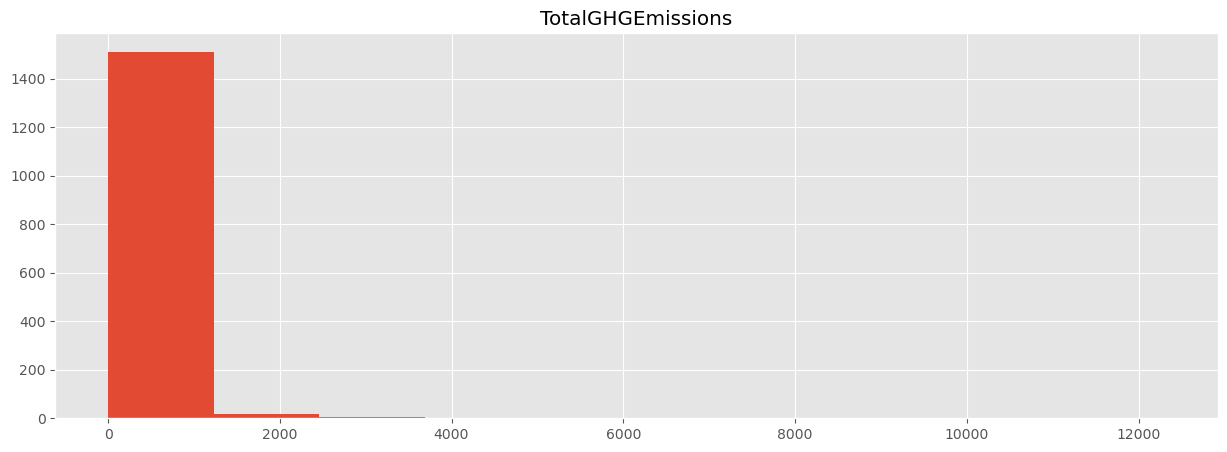

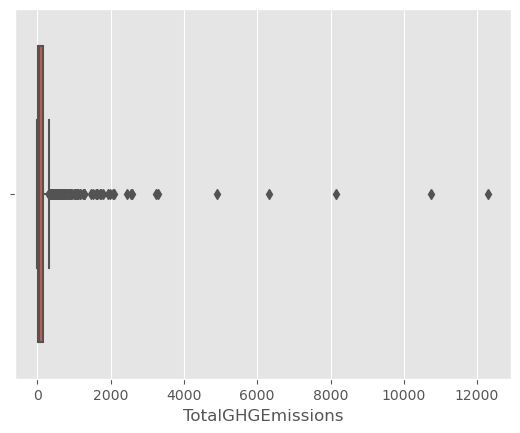

In [69]:
# Variable cible : TotalGHGEmissions (Unité : tonne)
dessinner_histogramme_boxplot(vars_float, 'TotalGHGEmissions', 'TotalGHGEmissions')

On constate que cette cible présente beaucoup d'outliers et que la plus des valeurs sont inférieur à 500 tonnes

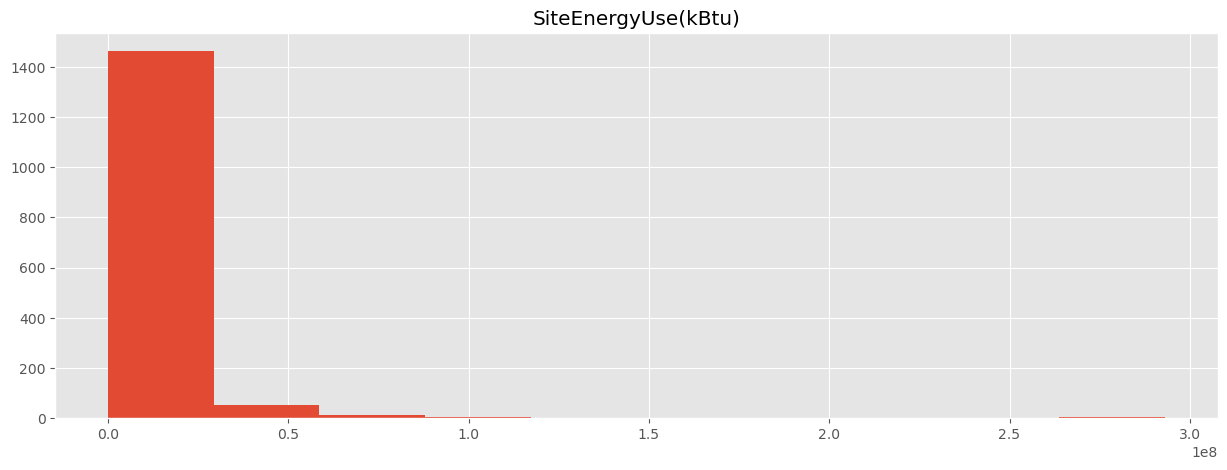

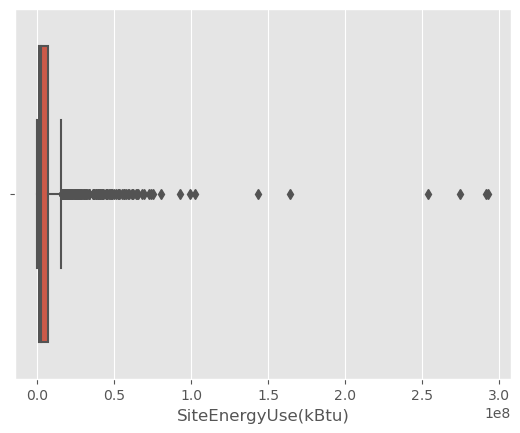

In [70]:
# Variable cible : SiteEnergyUse(kBtu) (Unité : tonne)
dessinner_histogramme_boxplot(vars_float, 'SiteEnergyUse(kBtu)', 'SiteEnergyUse(kBtu)')

Idem cette deuxiéme variable cible présente aussi beaucoup d'outliers

- Distributions des autres variables

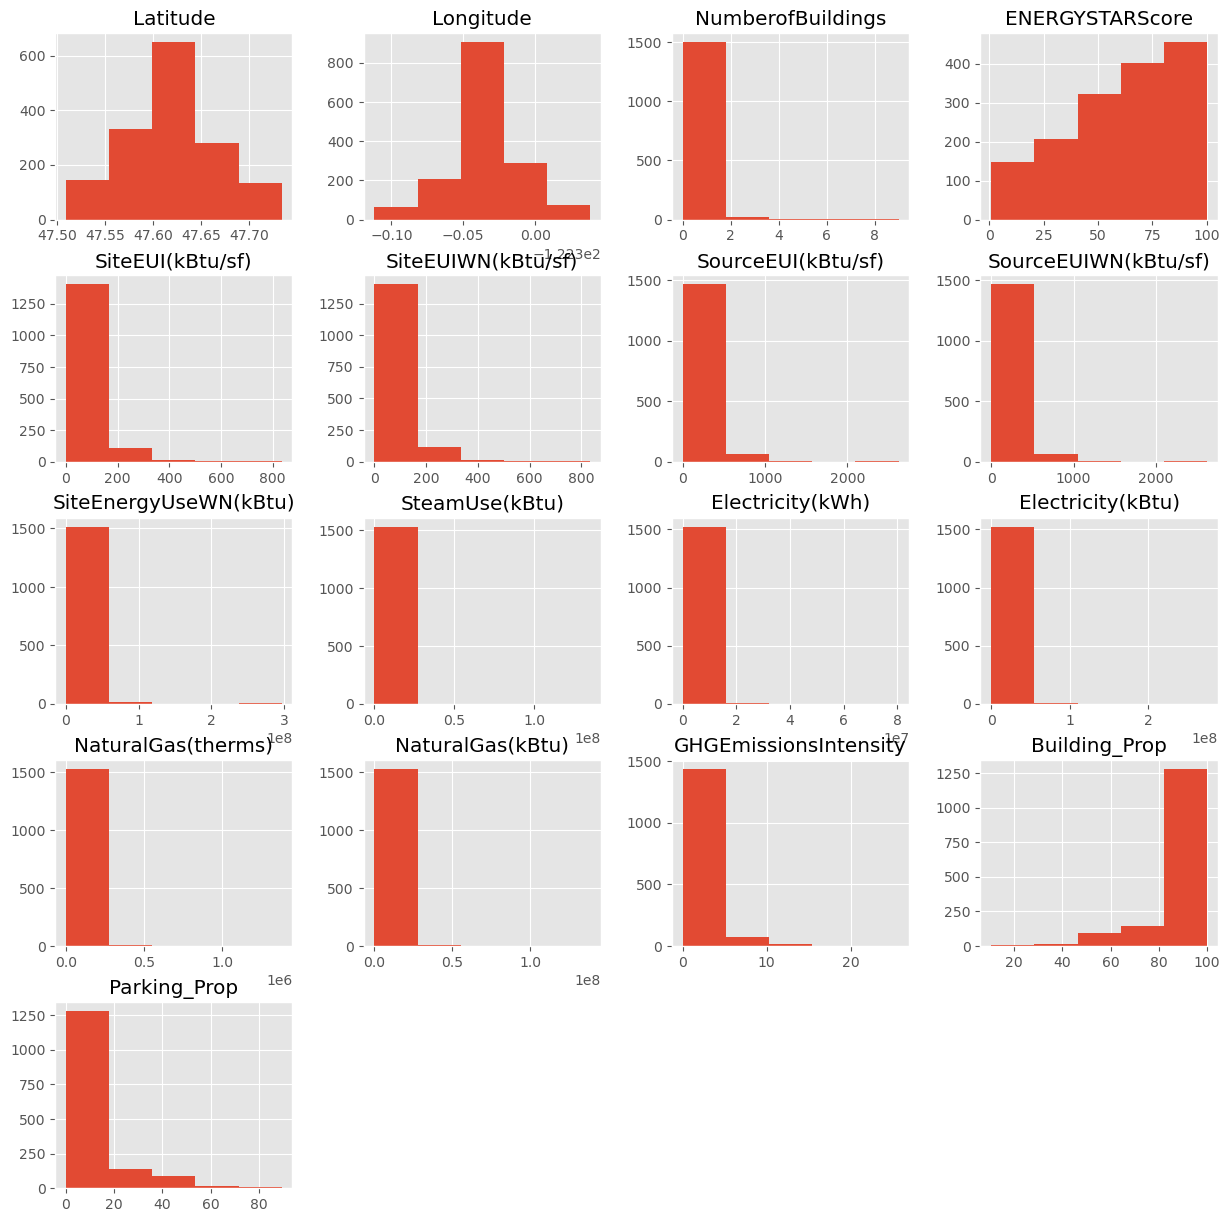

In [71]:
%matplotlib inline
vars_float.drop(['TotalGHGEmissions','SiteEnergyUse(kBtu)'],axis=1).hist(bins=5, figsize=(15,15))
plt.show()

Les variables **Latitude** et **Longitude** sont assymétriques

- Variables de type int

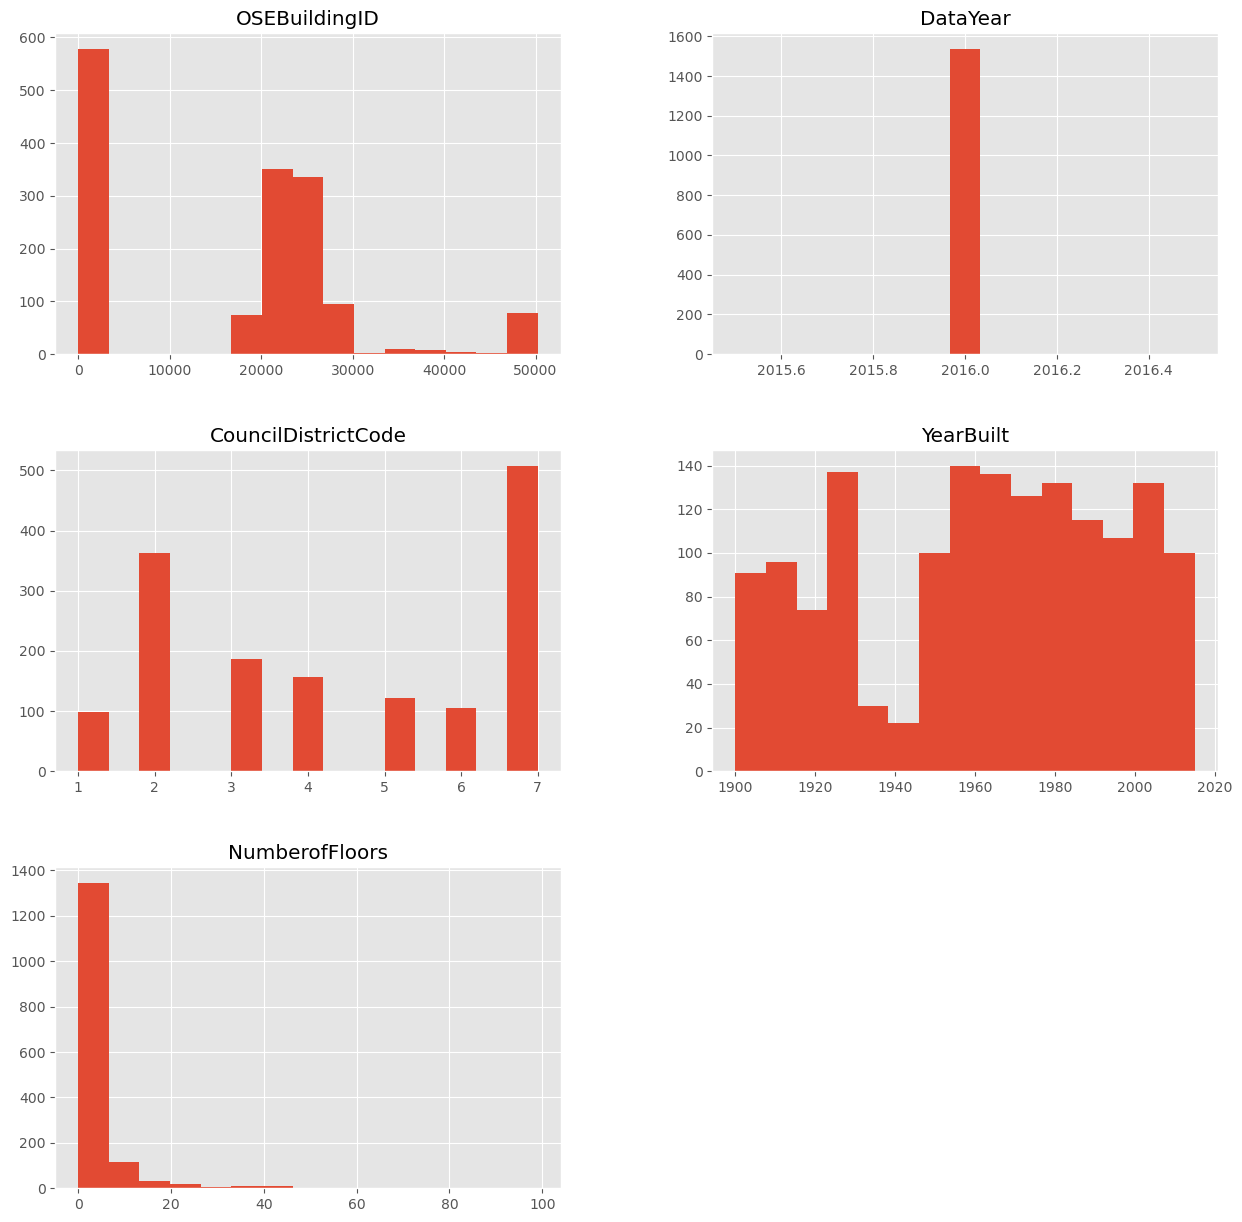

In [72]:
vars_int.hist(bins=15, figsize=(15,15))
plt.show()

La variable **NumberofFloors** nous indique que la majorité des propiétés ont moins de 10 étages et la variable **YearBuilt** nous enseigne qu'il y'avait moins de constructions pendant les années 30 et 40

### Répartition des valeurs des variables catégorielles

- Variables de type objet

In [73]:
catgoriel_columns = vars_objet.nunique()[(vars_objet.nunique() >1) & (vars_objet.nunique() < 50)].keys().to_list()
catgoriel_columns

['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'ComplianceStatus']

In [74]:
#Crétation d'une fonction de construction de graphiques à barres et de maniére interactive
def bar_plot(a):
    vars_objet[a].value_counts(normalize=True).plot(kind = 'bar')
    plt.ylabel('proportion')
    plt.title("Distribution de "+str(a))
    return plt.show() 

In [75]:
from ipywidgets import interact
interact(bar_plot, a = catgoriel_columns)

interactive(children=(Dropdown(description='a', options=('BuildingType', 'PrimaryPropertyType', 'Neighborhood'…

<function __main__.bar_plot(a)>

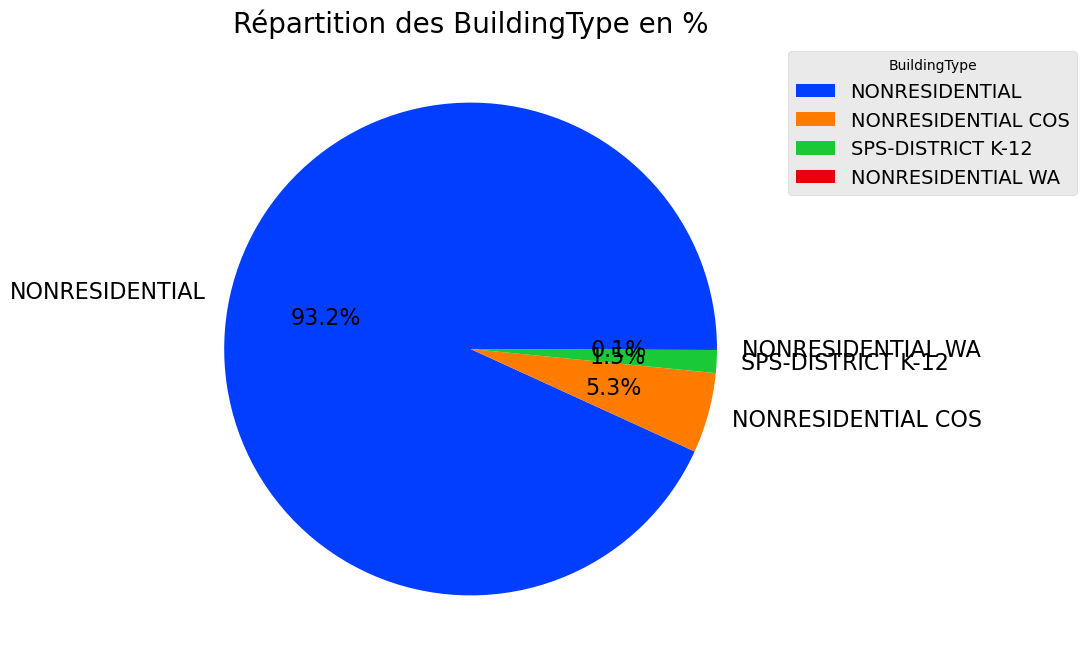

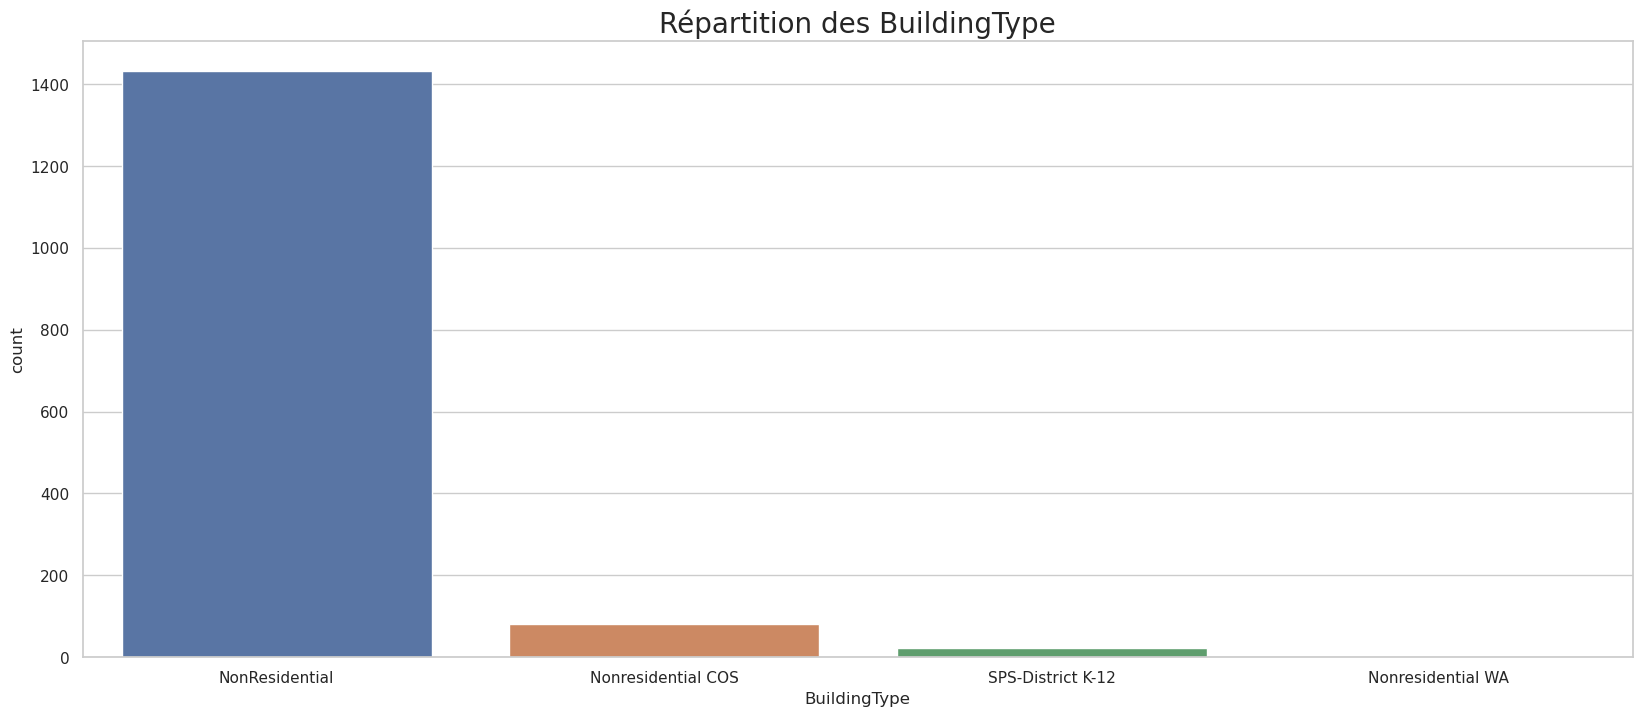

In [76]:
dessinerCamembert(vars_objet, 'BuildingType')

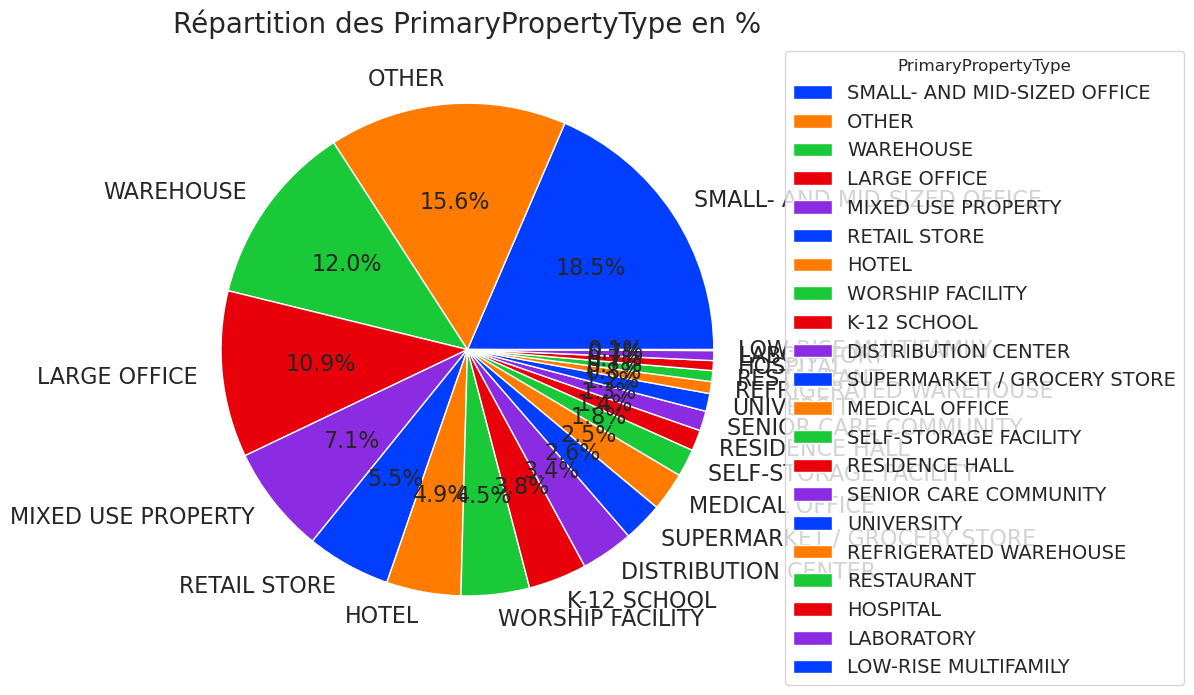

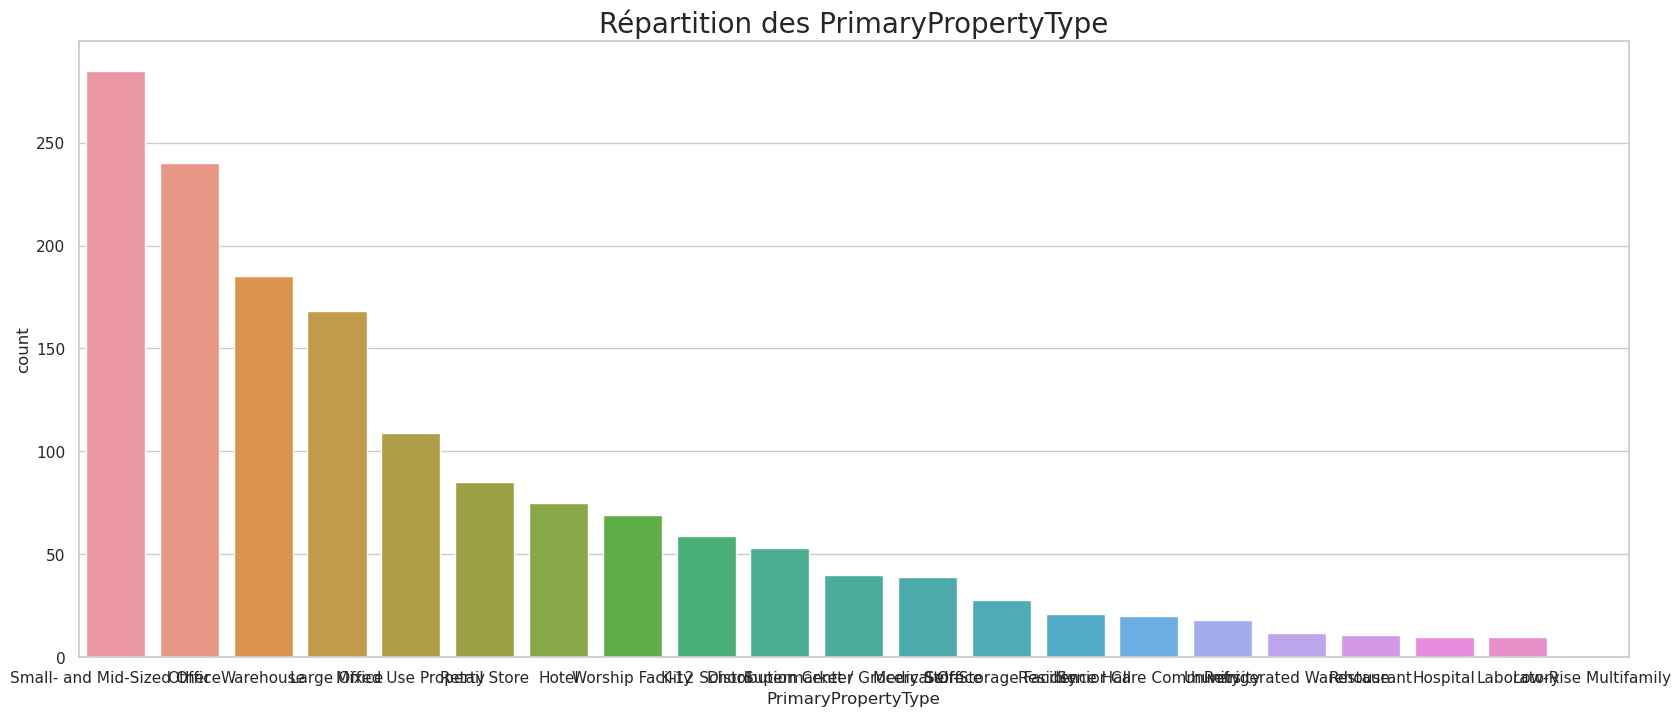

In [77]:
dessinerCamembert(vars_objet, 'PrimaryPropertyType')

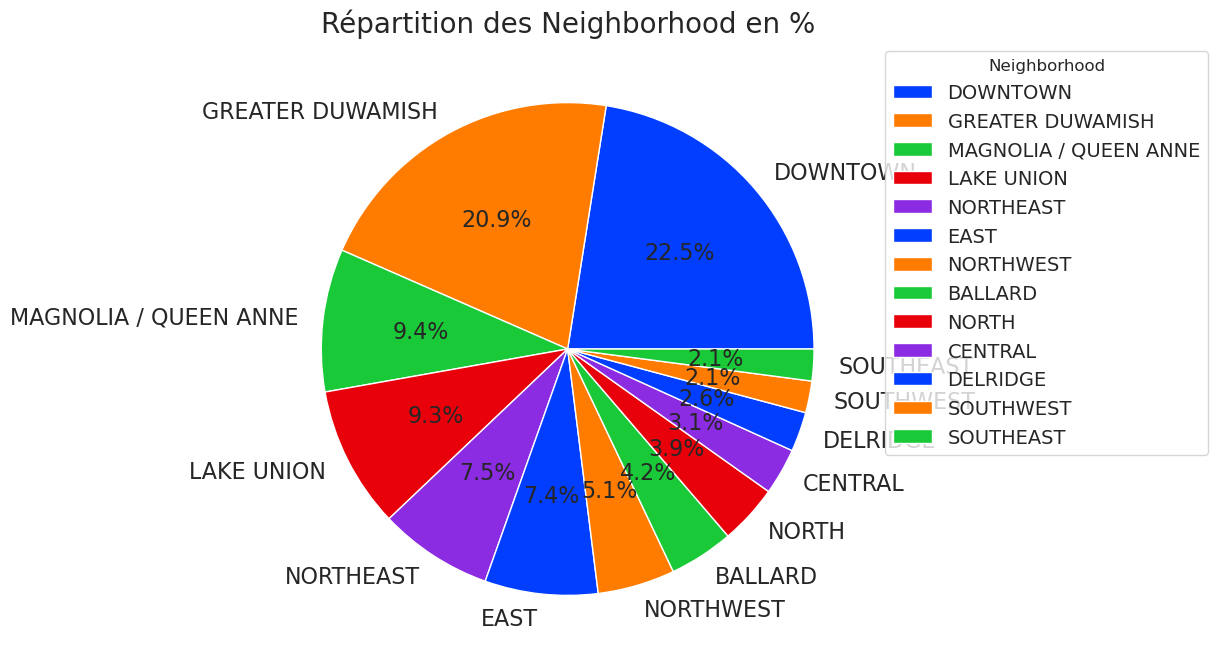

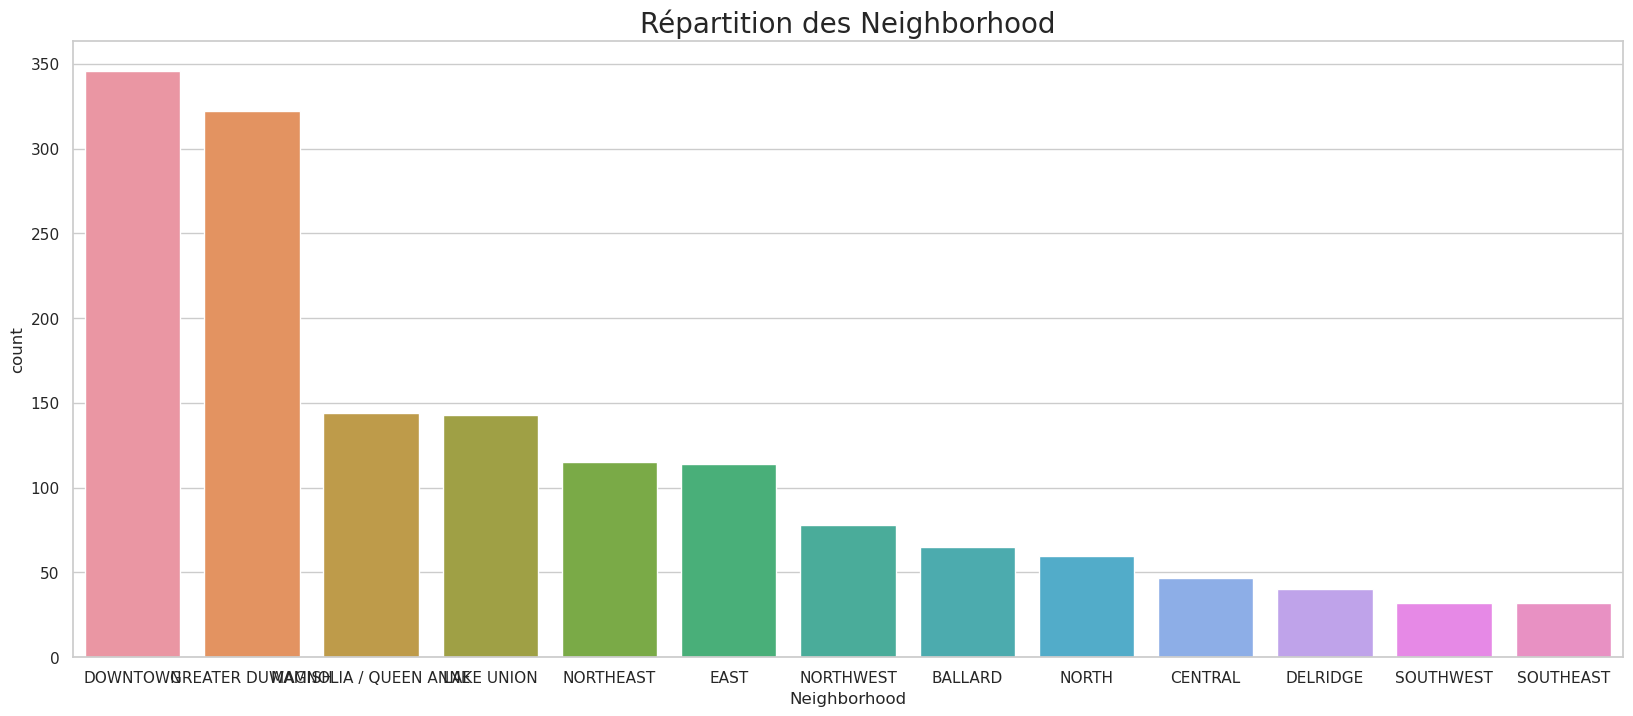

In [78]:
dessinerCamembert(vars_objet, 'Neighborhood')

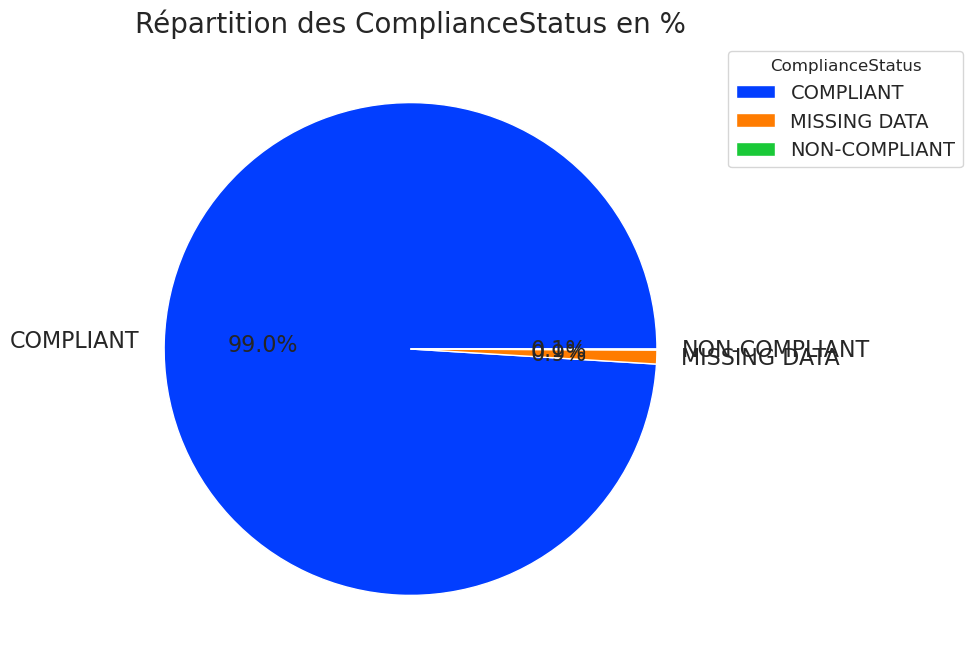

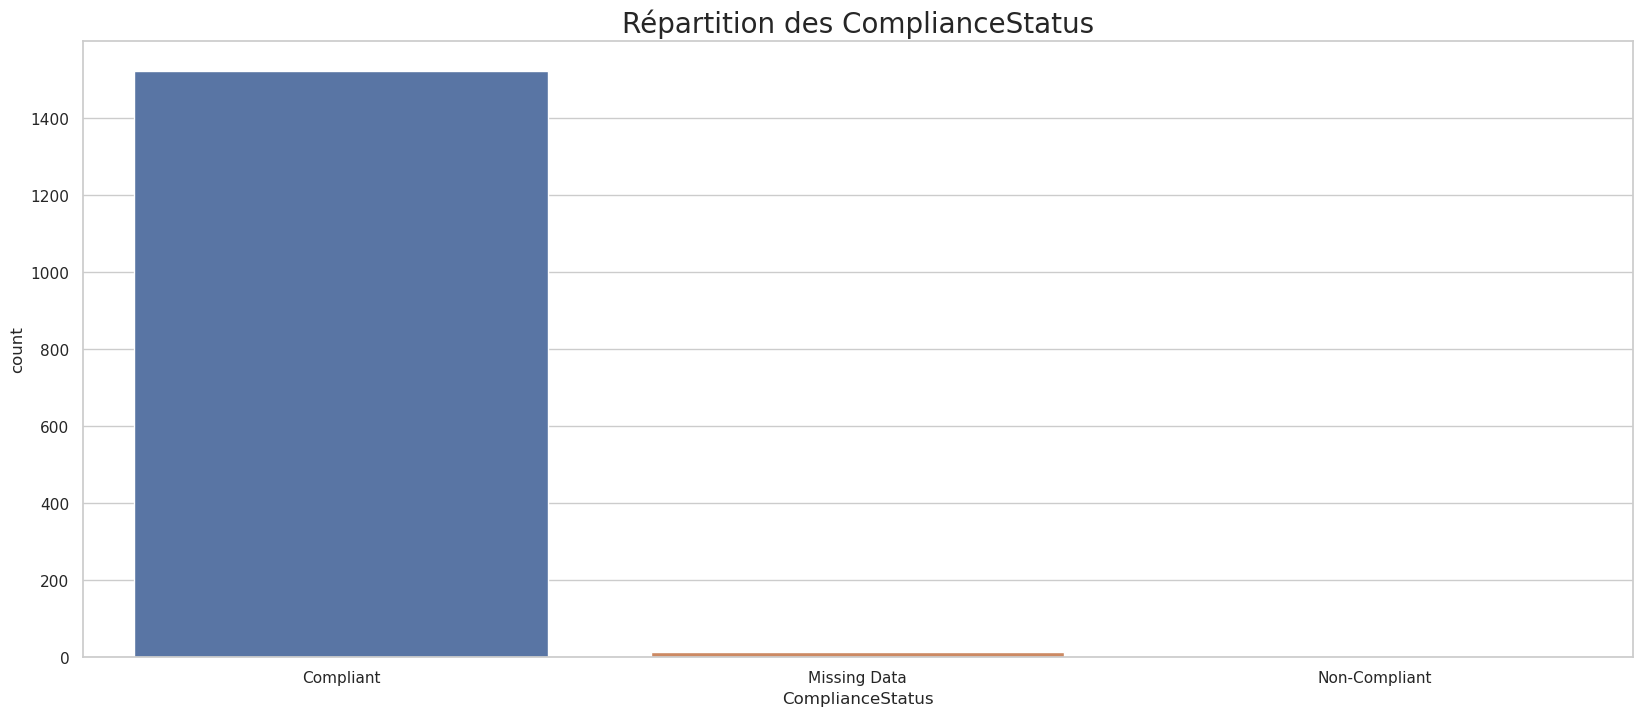

In [79]:
dessinerCamembert(vars_objet, 'ComplianceStatus')

- Séléction des variables pertinentes

In [80]:
data_pertinent = data_filled[['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofFloors','ComplianceStatus',
                             'Latitude', 'Longitude', 'NumberofBuildings', 'ENERGYSTARScore',
                             'Building_Prop', 'Parking_Prop', 'TotalGHGEmissions', 'SiteEnergyUse(kBtu)']].copy()

### Discritisation des variables catégorielles YearBuilt et NumberofFloors

- Discritisation de la variable 'YearBuilt'

In [94]:
decade = ['1900-1950',
          '1951-2020'
          ]

bins = [1900,1950,2020]                   
data_pertinent['DecadeBuilt'] = pd.cut(data_pertinent['YearBuilt'], bins, labels = decade, right=False)
data_pertinent[['YearBuilt','DecadeBuilt']].sort_values(by='YearBuilt')

,YearBuilt,DecadeBuilt
2404,1900,1900-1950
455,1900,1900-1950
2392,1900,1900-1950
464,1900,1900-1950
2406,1900,1900-1950
...,...,...
3324,2015,1951-2020
3322,2015,1951-2020
3317,2015,1951-2020
3347,2015,1951-2020


In [95]:
data_pertinent[['YearBuilt','DecadeBuilt']].sample(10)

,YearBuilt,DecadeBuilt
2686,1966,1951-2020
1280,1992,1951-2020
2185,1920,1900-1950
2521,1959,1951-2020
477,1912,1900-1950
368,1988,1951-2020
2199,1962,1951-2020
1391,1962,1951-2020
424,1948,1900-1950
1525,1975,1951-2020


- Discritisation de la variable 'NumberofFloors'

In [83]:
#NumberofFloors
floors = ['0-10','11-100']
bins_floors = [0,9,100]                   
data_pertinent['Floors'] = pd.cut(data_pertinent['NumberofFloors'], bins_floors, labels = floors, right=False)
data_pertinent[['NumberofFloors','Floors']].sort_values(by='NumberofFloors')

,NumberofFloors,Floors
3279,0,0-10
3276,0,0-10
3278,0,0-10
3130,0,0-10
3280,0,0-10
...,...,...
271,55,11-100
292,56,11-100
233,63,11-100
559,76,11-100


In [84]:
data_pertinent[['NumberofFloors','Floors']].sample(10)

,NumberofFloors,Floors
2800,2,0-10
209,17,11-100
442,3,0-10
2913,2,0-10
3294,3,0-10
3020,3,0-10
291,4,0-10
2259,2,0-10
416,5,0-10
3000,2,0-10


### Encodage de variables catégorielles

- DecadeBuilt

In [85]:
data_encoded = encodage_cat_dummies(data_pertinent, 'DecadeBuilt', 'decade')

['1900-1950', '1951-2000']
Categories (2, object): ['1900-1950' < '1951-2000']


In [98]:
data_encoded[['DecadeBuilt','decade_1900-1950','decade_1951-2000']].sample(10)

,DecadeBuilt,decade_1900-1950,decade_1951-2000
787,1900-1950,1,0
65,1951-2000,0,1
266,1951-2000,0,1
526,1900-1950,1,0
265,1951-2000,0,1
1972,1951-2000,0,1
2148,1951-2000,0,1
127,1900-1950,1,0
3108,1951-2000,0,1
623,1951-2000,0,1


- Floors

In [101]:
data_encoded = encodage_cat_dummies(data_encoded, 'Floors', 'Floors')

['11-100', '0-10']
Categories (2, object): ['0-10' < '11-100']


In [103]:
data_encoded[['Floors','floors_0-10','floors_11-100']].sample(10)

,Floors,floors_0-10,floors_11-100
2999,0-10,1,0
478,0-10,1,0
2151,0-10,1,0
579,0-10,1,0
441,0-10,1,0
2680,0-10,1,0
2379,0-10,1,0
911,0-10,1,0
627,0-10,1,0
2739,0-10,1,0


- PrimaryPropertyType

In [87]:
data_encoded = encodage_cat_dummies(data_encoded, 'PrimaryPropertyType', 'PPT')

['Hotel' 'Other' 'Mixed Use Property' 'University' 'K-12 School'
 'Small- and Mid-Sized Office' 'Self-Storage Facility' 'Warehouse'
 'Large Office' 'Senior Care Community' 'Medical Office' 'Retail Store'
 'Hospital' 'Residence Hall' 'Distribution Center' 'Worship Facility'
 'Supermarket / Grocery Store' 'Laboratory' 'Refrigerated Warehouse'
 'Restaurant' 'Low-Rise Multifamily']


In [104]:
data_encoded[['PrimaryPropertyType','PPT_Distribution Center', 'PPT_Hospital', 'PPT_Hotel',
       'PPT_K-12 School', 'PPT_Laboratory', 'PPT_Large Office',
       'PPT_Medical Office', 'PPT_Mixed Use Property', 'PPT_Other',
       'PPT_Refrigerated Warehouse', 'PPT_Residence Hall', 'PPT_Restaurant',
       'PPT_Retail Store', 'PPT_Self-Storage Facility',
       'PPT_Senior Care Community', 'PPT_Small- and Mid-Sized Office',
       'PPT_Supermarket / Grocery Store', 'PPT_University', 'PPT_Warehouse',
       'PPT_Worship Facility']].sample(10)

,PrimaryPropertyType,PPT_Distribution Center,PPT_Hospital,PPT_Hotel,PPT_K-12 School,PPT_Laboratory,PPT_Large Office,PPT_Medical Office,PPT_Mixed Use Property,PPT_Other,PPT_Refrigerated Warehouse,PPT_Residence Hall,PPT_Restaurant,PPT_Retail Store,PPT_Self-Storage Facility,PPT_Senior Care Community,PPT_Small- and Mid-Sized Office,PPT_Supermarket / Grocery Store,PPT_University,PPT_Warehouse,PPT_Worship Facility
2775,Residence Hall,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3060,Warehouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1621,Small- and Mid-Sized Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
589,Warehouse,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
412,Distribution Center,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1302,Small- and Mid-Sized Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
243,Large Office,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1054,Worship Facility,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
78,Small- and Mid-Sized Office,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
697,Laboratory,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


- Supprimer les variables qui n'ont pas une porté structurelle

In [89]:
vars_to_delete = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt',
                  'NumberofFloors', 'ComplianceStatus', 'NumberofBuildings',
                  'DecadeBuilt', 'Floors',
                 ]

In [90]:
data_finale = data_encoded.drop(vars_to_delete, axis=1).copy()

In [128]:
df1 = formats(data_finale, '')
df2 = vars_types(data_finale)
dfs = {'Jeu de données final': df1, 'Types de variables': df2}
display_dfs(dfs, justify='flex-start')

Jeu de données final 

 
 
 
 
 Nbre de lignes 
 Nbre de variables 
 
 
 
 
 
 1538 
 32 
 
 
 
 Types de variables 

 
 
 
 
 Objet 
 Float 
 Int 
 Bool 
 
 
 
 
 
 0 
 32 
 0 
 0

### Corrélation entre variables

<AxesSubplot:>

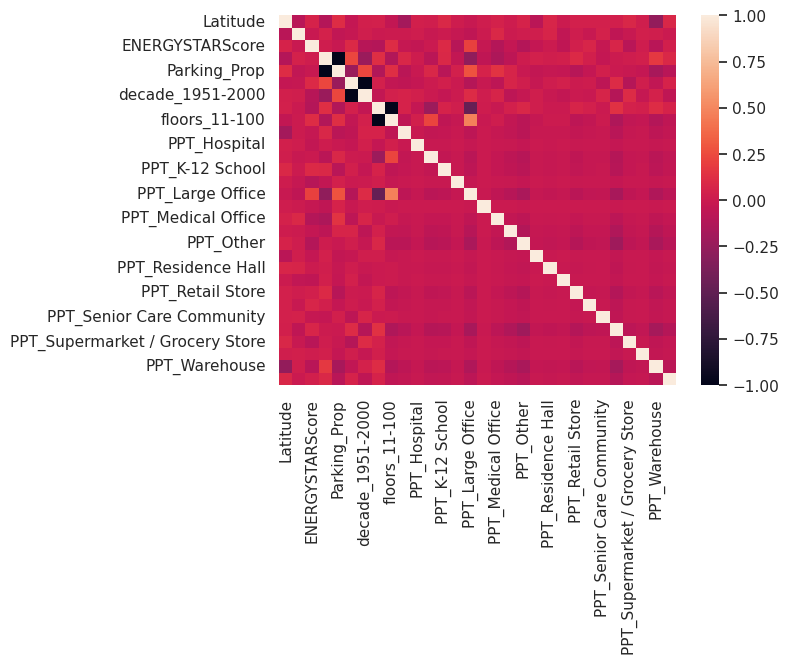

In [130]:
corr = data_finale.drop(['SiteEnergyUse(kBtu)','TotalGHGEmissions'], axis=1).corr()
sns.heatmap(corr)

On remarque qu'il n'a pas de corrélation entre nos variables

### Enregistrer le dataset final sous format csv

In [132]:
data_finale.to_csv("data/Seattle_table.csv", index=False)

### Fin